## TASK 2 ##

Using the 1- and 2-layer Galton Box code as a starting point, I have written the general algorithm that generates a circuit for any number of layers.

In [6]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.circuit.library import CSwapGate
import numpy as np

1 - layer QGB 

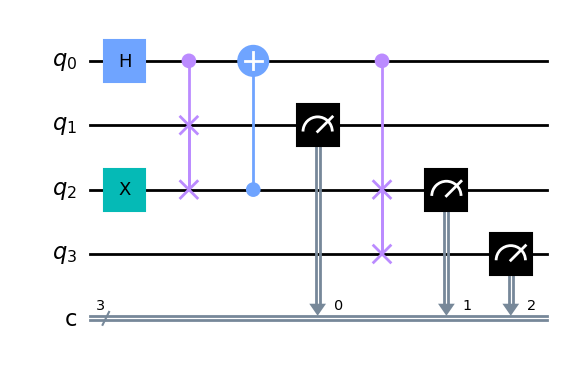

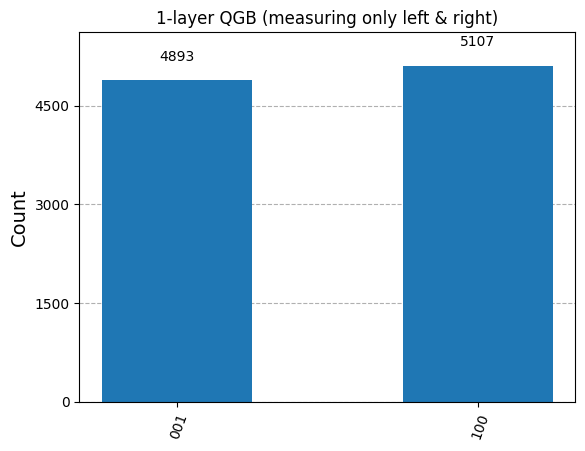

In [7]:
qc = QuantumCircuit(4, 3)  # q[0]=coin, q[1:4]=positions

# Initialize ball at center position (q2)
qc.x(2)
# Put control qubit in superposition
qc.h(0)

# Controlled-SWAP operation on q1 and q2
qc.append(CSwapGate(), [0, 1, 2])

#CNOT 
qc.cx(2, 0) 

# Controlled-SWAP operation on q2 and q3
qc.append(CSwapGate(), [0, 2, 3])

# Measure position qubits
qc.measure(1, 0)  # q1 -> c[0]
qc.measure(2, 1)  # q2 -> c[1] 
qc.measure(3, 2)  # q3 -> c[2]

# Show circuit diagram
qc.draw(output='mpl', style='clifford', fold=1)
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title("1-layer QGB (measuring only left & right)")
plt.show()


2 - layer QGB 

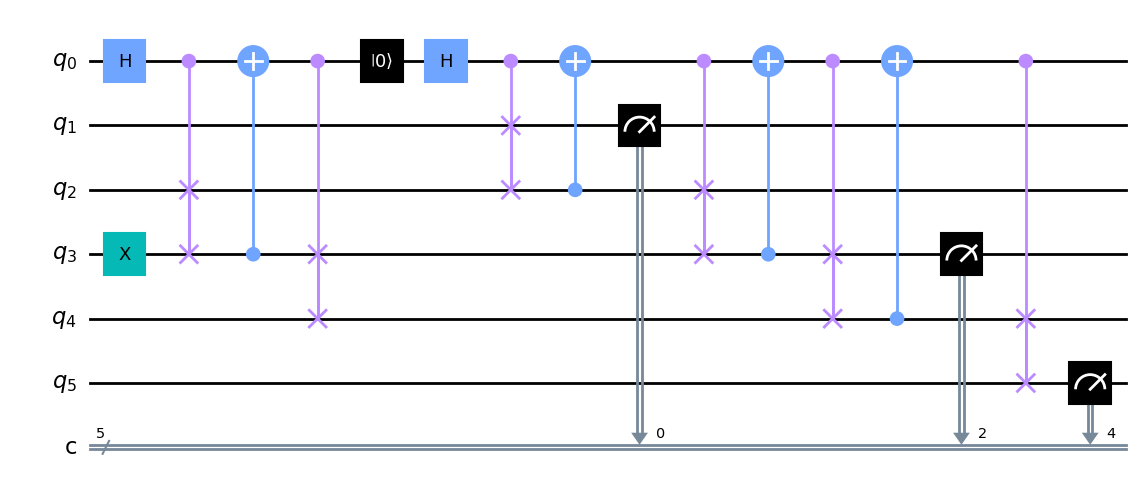

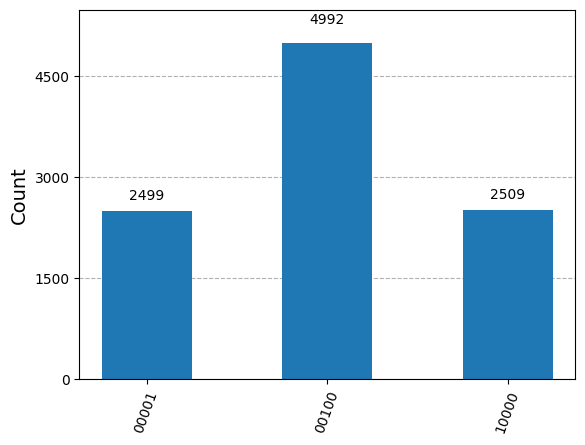

In [8]:
# 1 coin qubit + 5 position qubits, and 5 classical bits
qc = QuantumCircuit(6, 5)

# Naming: q[0] = coin, q[1]–q[5] = position qubits

# Initial position: put particle at center (q[3])
qc.x(3)

# === Layer 1 ===
qc.h(0)  # Hadamard on coin
qc.append(CSwapGate(), [0, 2, 3]) 
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])  

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])  
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])   
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4]) 
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5]) 

# Measurement
qc.measure(1, 0)
qc.measure(3, 2)
qc.measure(5, 4)

# Show the circuit
qc.draw(output='mpl', style='clifford', fold=1)
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()


3 - layer QGB 

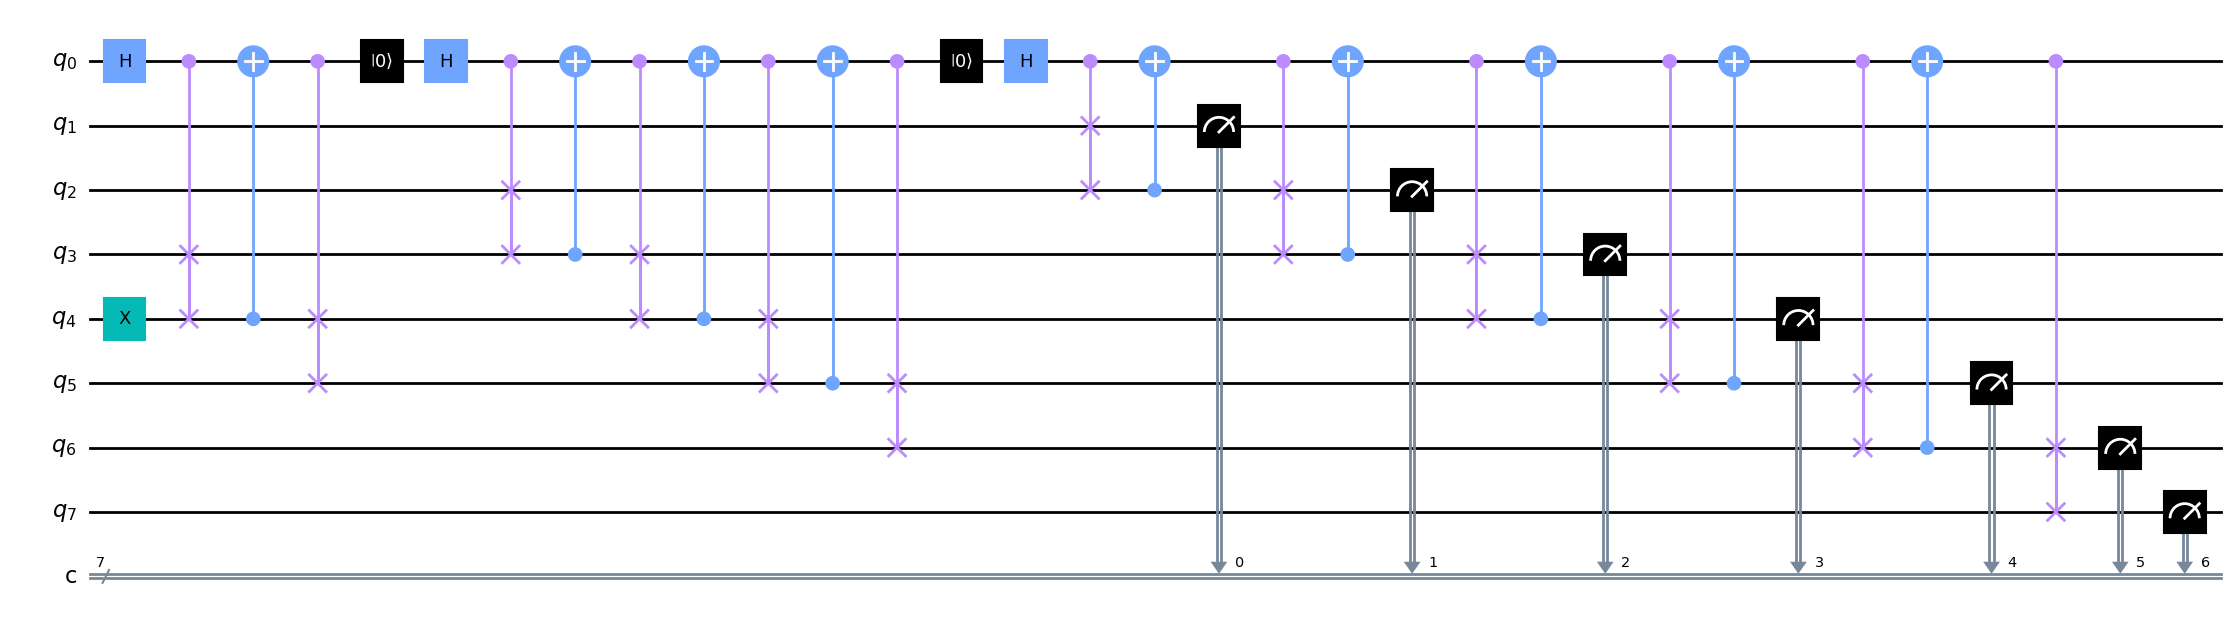

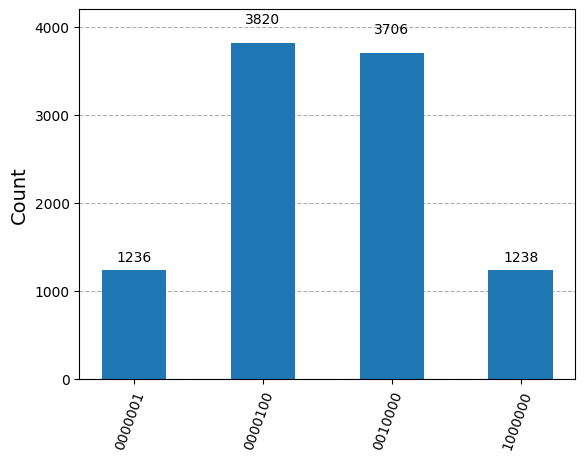

In [9]:
qc = QuantumCircuit(8, 7)

# Initial position: place particle at center (q[4])
qc.x(4)

# === Layer 1 ===
qc.h(0)                             # Hadamard on coin
qc.append(CSwapGate(), [0, 3, 4])   # swap q2 and q3 if coin is 1
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])   # swap q3 and q4 if coin is 1

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 2, 3])
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])
qc.cx(5, 0)
qc.append(CSwapGate(), [0, 5, 6])

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 3 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])
qc.cx(5, 0)
qc.append(CSwapGate(), [0, 5, 6])
qc.cx(6, 0)
qc.append(CSwapGate(), [0, 6, 7])

# Measurement
qc.measure(1, 0)  
qc.measure(2, 1) 
qc.measure(3, 2)  
qc.measure(4, 3) 
qc.measure(5, 4)  
qc.measure(6, 5)
qc.measure(7, 6)

# Visualize circuit
qc.draw(output='mpl', style='clifford', fold = 1)
plt.show()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()

n - layer QGB generalisation

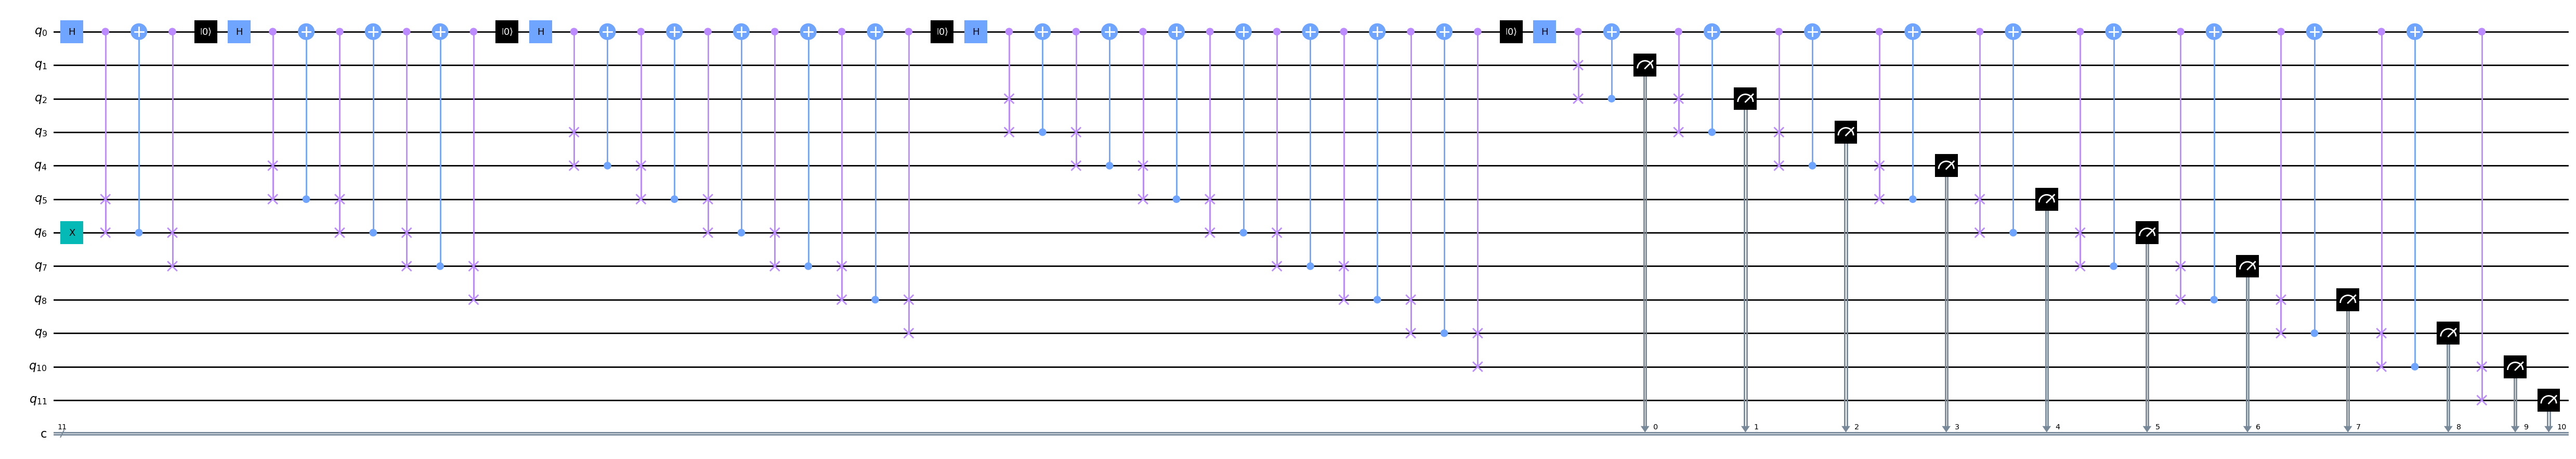

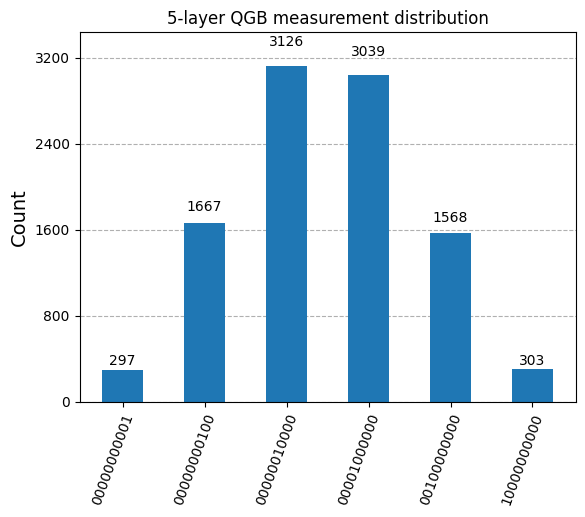

Top outcomes (counts):
00000010000 3126
00001000000 3039
00000000100 1667
00100000000 1568
10000000000 303
00000000001 297


In [10]:

def build_qgb(n_layers: int, measure_all_positions: bool = True):
    """
    Build an n-layer Quantum Galton Board QGB.
    - coin qubit = q[0]
    - position qubits = q[1] .. q[2n+1]
    - total qubits = 2n + 2
    - classical bits = number of position qubits (2n+1) by default
    Returns: QuantumCircuit object
    """
    if n_layers < 1:
        raise ValueError("n_layers must be >= 1")
    num_positions = 2 * n_layers + 1
    total_qubits = num_positions + 1      # +1 for coin
    qc = QuantumCircuit(total_qubits, num_positions)

    coin = 0
    # position indices run 1 .. 2n+1
    center = n_layers + 1  # q[index of center position]

    # initialize the ball at center
    qc.x(center)

    # For each layer k = 1..n_layers
    for k in range(1, n_layers + 1):
        # coin into superposition
        qc.h(coin)

        # produce list of adjacent pairs (j, j+1) for this layer
        # j ranges from (center - k) to (center + k - 1) inclusive
        pairs = [(j, j + 1) for j in range(center - k, center + k)]

        # apply cswap(coin, j, j+1) for each pair
        # and inverted CNOT (cx(j+1, coin)) after each cswap except the final one
        for i, (a, b) in enumerate(pairs):
            # controlled swap: control=coin, swap a <-> b
            qc.cswap(coin, a, b)
            # inverted CNOT to restore coin bias, except after last cswap in this layer
            if i < len(pairs) - 1:
                qc.cx(b, coin)

        # reset coin to |0> before next layer (unless last layer)
        if k < n_layers:
            qc.reset(coin)

    # Measurements: by default measure all positions q[1..2n+1]
    if measure_all_positions:
        for i, pos in enumerate(range(1, num_positions + 1)):
            qc.measure(pos, i)

    return qc


def simulate_qgb(n_layers: int, shots: int = 1000, measure_all_positions: bool = True, plot: bool = True):
    qc = build_qgb(n_layers, measure_all_positions=measure_all_positions)

    # Draw the circuit in your preferred style
    qc.draw(output='mpl', style='clifford', fold=1)
    plt.show()

    sim = AerSimulator()
    compiled = transpile(qc, sim)
    job = sim.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if plot:
        plot_histogram(counts)
        plt.title(f"{n_layers}-layer QGB measurement distribution")
        plt.show()

    return qc, counts

# Example usage:
# Build & simulate a 3-layer QGB
qc3, counts3 = simulate_qgb(5, shots=10000)
print("Top outcomes (counts):")
for state, c in sorted(counts3.items(), key=lambda x: -x[1])[:10]:
    print(state, c)
